<div hidden=True>
    author: Marco Angius
    company: TomorrowData srl
    mail: marco.angius@tomorrowdata.io
    notebook-version: nov20-2.1
    
</div>

# Hands-on 3: Supervised Learning
### Version 2.1
This section is meant for learning the Scikit-Learn APIs end provide a playground for machine learning supervised tasks.

[Scikit-Learn](https://scikit-learn.org/stable/index.html#) is a library for data mining and data analysis. It  includes models for classification, regression and clustering. It is built on top of NumPy. SciPy and matplotlib. 

For the purpose of this playground, to get familiar with the Scikit-Learn APis, we would use [Toy Datasets](https://scikit-learn.org/stable/datasets/index.html#toy-datasets) available in the library. 

Datasets in `sklearn.datasets` return a *Bunch*:
> Dictionary-like object, the interesting attributes are: ‘data’, the data to learn, ‘target’, the regression targets, ‘DESCR’, the full description of the dataset, and ‘filename’, the physical location of boston csv dataset (added in version 0.20).

### mglearn library 
For visualizing the results obtained with our models we are going to employ an existing library made by Andreas C. Muller (author of the book *Introduction to Machine Learning with Python*). The library is available in the [github repository](https://github.com/amueller/mglearn).

In [274]:
!pip install mglearn==0.1.9

In [275]:
from sklearn.datasets import load_boston, load_diabetes, load_iris, load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import export_graphviz

from IPython.display import Image
from six import StringIO

import pydotplus
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn
import math

In [276]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn
import math

In [277]:
R_STATE = 99

## Utility Functions

In [278]:
def plot_visual_boundaries(dataset, ranges, model=KNeighborsClassifier):
    # use only the first 2 features if more than 2 features
    X, y = dataset.data[:, :2] if dataset.data.shape[1] > 2 else dataset.data, dataset.target
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=R_STATE)
    assert len(ranges) <= 3, "ranges lenght should be less or equal 3"
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    for n_neighbors, ax in zip(ranges, axes):
        cknn_ = model(n_neighbors=n_neighbors).fit(X_train, y_train)
        mglearn.plots.plot_2d_separator(cknn_, X_test, fill=True, eps=0.5, ax=ax, alpha=.4)
        mglearn.discrete_scatter(X_test[:, 0], X_test[:, 1], y_test, ax=ax)
        ax.set_title("{} neighbor(s)".format(n_neighbors), fontdict={'fontsize':15})
        ax.set_xlabel(dataset.feature_names[0], fontdict={'fontsize':13})
        ax.set_ylabel(dataset.feature_names[1], fontdict={'fontsize':13})

In [279]:
def k_search_classification(dataset, ranges, random_state=R_STATE):
    X, y = dataset.data, dataset.target
    X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=random_state)
    
    training_accuracy = []
    test_accuracy = []
    neighbors_settings = ranges
    for n in neighbors_settings:
        cknn_ = KNeighborsClassifier(n_neighbors=n)
        cknn_.fit(X_train, y_train)
        training_accuracy.append(cknn_.score(X_train, y_train))
        test_accuracy.append(cknn_.score(X_test, y_test))
    
    plt.figure(figsize=[10, 5])
    plt.title("Accuracy for different k values", size=15)
    plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
    plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
    plt.ylabel("Accuracy", size=13)
    plt.xlabel("n_neighbors", size=13)
    plt.legend()

In [280]:
def plot_regression(dataset, ranges, f_number=5):
    X, y = dataset.data[::4, f_number], dataset.target[::4]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=R_STATE)
    assert len(ranges) <= 3, "ranges lenght should be less or equal 3"
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    line = np.linspace(min(X_train), max(X_train), 1000).reshape(-1, 1)
    for n_neighbors, ax in zip(ranges, axes):
        rknn_ = KNeighborsRegressor(n_neighbors=n_neighbors)
        rknn_.fit(X_train.reshape(-1, 1), y_train)
        ax.plot(line, rknn_.predict(line))
        ax.plot(X_train, y_train, '^', c=mglearn.cm2(0), markersize=8)
        ax.plot(X_test, y_test, 'v', c=mglearn.cm2(1), markersize=8)
        ax.set_title("{} neighbor(s)\n train score: {:.2f} test score: {:.2f}".format(
            n_neighbors, 
            rknn_.score(X_train.reshape(-1,1), y_train),
            rknn_.score(X_test.reshape(-1,1), y_test)))
        ax.set_xlabel("Feature")
        ax.set_ylabel("Target")
        axes[0].legend(["Model predictions", "Training data/target","Test data/target"], loc="best")

In [281]:
def k_search_regression(dataset, ranges):
    X, y = dataset.data, dataset.target
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=R_STATE)
    
    training_accuracy = []
    test_accuracy = []
    neighbors_settings = ranges
    for n in neighbors_settings:
        rknn_ = KNeighborsRegressor(n_neighbors=n)
        rknn_.fit(X_train, y_train)
        training_accuracy.append(mean_squared_error(y_train, rknn_.predict(X_train)))
        test_accuracy.append(mean_squared_error(y_test, rknn_.predict(X_test)))
    
    plt.figure(figsize=[10, 5])
    plt.title("MSE for different k values", size=15)
    plt.plot(neighbors_settings, training_accuracy, label="training mse")
    plt.plot(neighbors_settings, test_accuracy, label="test mse")
    plt.ylabel("MSE", size=13)
    plt.xlabel("n_neighbors", size=13)
    plt.legend()

In [282]:
def plot_coefficients_given_models(dataset, models):
    models = [models] if not isinstance(models, list) else models
    
    f = plt.figure(figsize=[12, 7])
    ax = f.add_subplot()
    for m in models:
        ax.plot(range(0, len(dataset.feature_names)), m.coef_, 's', 
                label=str(m.__class__).strip("<>''").split(".")[-1])
    
    ax.set_title("Coefficients magnitued", fontdict={'fontsize':15})
    ax.set_ylabel("Coefficient index", fontdict={'fontsize':13})
    ax.set_xlabel("Features", fontdict={'fontsize':13})
    ax.hlines(0, 0, len(m.coef_))
    ax.set_xticks(range(0, len(dataset.feature_names)))
    ax.set_xticklabels(dataset.feature_names)
    xlabels = ax.get_xticklabels()
    ax.set_xticklabels(xlabels, rotation=90)
    plt.legend()

## Dataset load
We will use the **boston house prices** and the **diabetes** dataset for regressions tasks. The **iris** and the **breast cancer** are used for multi-class and binary-class classification tasks respectively. 

In [284]:
boston_houses_ds = load_boston()
iris_ds = load_iris()
diabetes_ds = load_diabetes()
breast_ds = load_breast_cancer()

<div class="alert alert-info" role="alert">
    
<img src="./icons/list.png"  width="20" height="20" align="left"> &nbsp;  **Exercise 1**
- check the datasets. Use `print(ds.DESCR)`to print information for each of them.

</div>

In [13]:
print(boston_houses_ds.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

<hr>

## Linear Models
The next model we are going to use predict the target by means of a linear function of the input features.
The general formula for regression tasks is: 

$$ \hat{y} = w[0] * x[0] + w[1] * x[1] + \dots + w[p] * x[p] + b $$

We have also seen that in the case of classification tasks we can employ a linear model for defining decision boundaries: 

$$ \hat{y} = w[0] * x[0] + w[1] * x[1] + \dots + w[p] * x[p] + b > 0 $$

For now we focus on regression tasks only

<div class="alert alert-success" role="alert">
    
<img src="./icons/lightbulb.png"  width="20" height="20" align="left"> &nbsp; **SciKit-Learn Tip 1: Models**

Models in scikit-learn follow all the same API. 

- to fit a model use the `model.fit(X_training, y_training)`
- to make predictions use the `model.predict(X_test)`

In order to split the available data X,y in training and test use the `sklearn.model_selection.train_test_split(X, y)` function.

</div>

<div class="alert alert-success" role="alert">
    
<img src="./icons/lightbulb.png"  width="20" height="20" align="left"> &nbsp; **SciKit-Learn Tip 2: Metrics**

Also it is possible to evaluate the results by means of metrics. There are metrics for [classification](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) and [regression](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics).

For now just use `metrics.accuracy_score(y_true, y_pred)` for classification tasks and `metrics.mean_squared_error(y_true, y_pred)` for regression tasks.

</div>


Let's start by plotting some random data and fitting a simple linear regressor. We will create the "unknown function" that generates the data and then will add some noise. 

In [294]:
np.random.seed(33)
w1, b = 0.011, 12                                      # slope and intercept
x1 = np.linspace(0, 40000, num=100)                    # define features
y = (b + w1 * x1)                                      # define the unknown function
y = y + np.random.randint(-50, 50, size=len(y))        # add noise 

In [295]:
def plot_examples(x1, y):
    fig = plt.figure(figsize=(15, 10)) 
    ax = fig.add_subplot()
    ax.scatter(x1, y, color='m', label='examples')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.grid()
    ax.legend(loc='upper left')
    _ = ax.set_title("Toy Case: examples")
    _ = ax.set_xlabel('x1', rotation=0, labelpad=10, fontdict={'size':14})
    _ = ax.set_ylabel('y', rotation=0, labelpad=40, fontdict={'size':14})

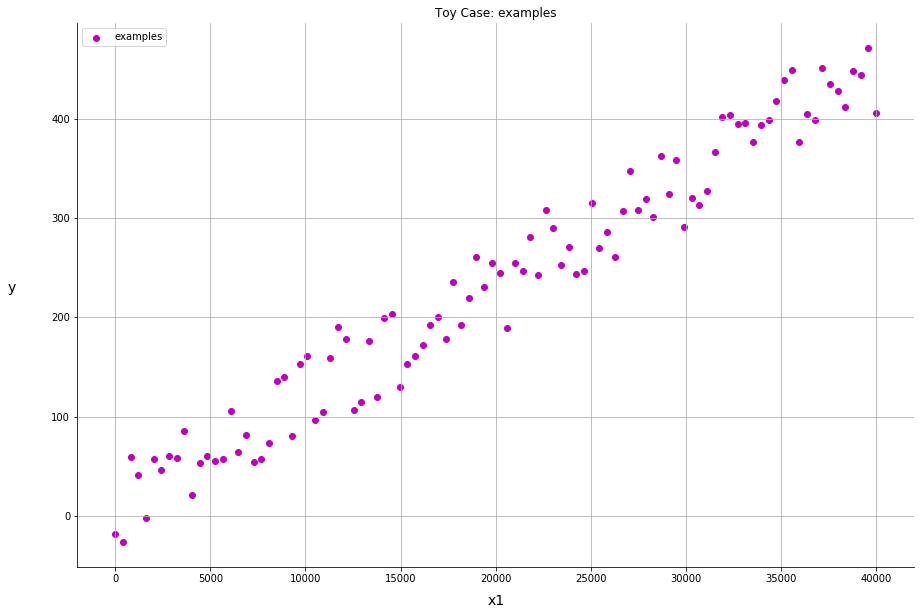

In [296]:
plot_examples(x1, y)

In [301]:
x1 = x1.reshape(-1, 1)

In [302]:
lrt = LinearRegression()

In [306]:
#  fit model
lrt.fit(x1, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [307]:
# predict points
y_pred = lrt.predict(x1)

In [308]:
lrt.coef_

array([0.01119289])

In [309]:
lrt.intercept_

7.542178217821856

In [310]:
def plot_examples_with_pred_f(x1, y, y_est):
    fig = plt.figure(figsize=(15, 10)) 
    ax = fig.add_subplot()
    ax.plot(x1, y_est, label='linear model')
    # plot error distances
    for y_, y_n, x_ in zip(y, y_noise, X): 
        plt.vlines(x1, y_est, y, linestyle='dashed')
    ax.scatter(x1, y, color='m', label='examples')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.grid()
    ax.legend(loc='upper left')
    _ = ax.set_title("Toy Case: examples")
    _ = ax.set_xlabel('x1', rotation=0, labelpad=10, fontdict={'size':14})
    _ = ax.set_ylabel('y', rotation=0, labelpad=40, fontdict={'size':14})

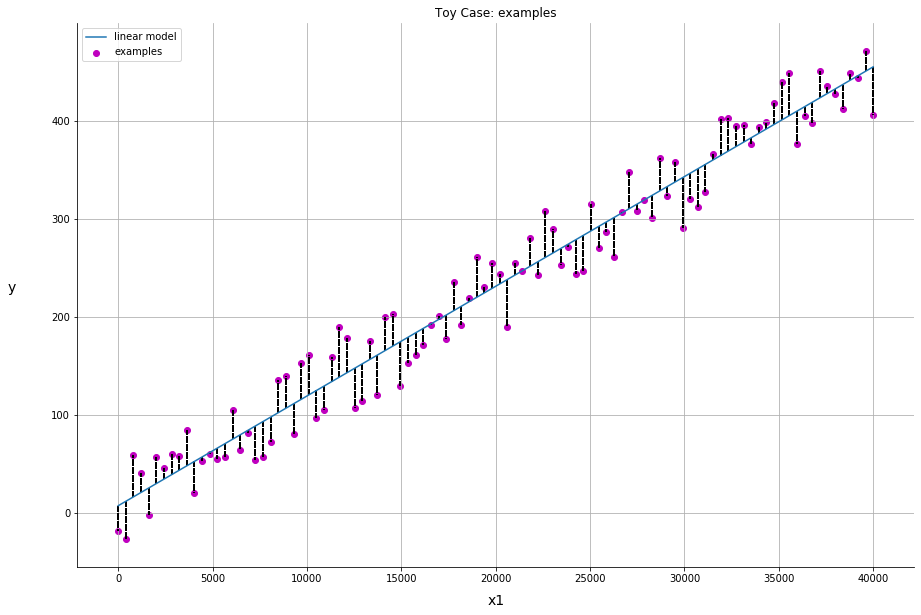

In [311]:
plot_examples_with_pred_f(x1, y, y_pred)

<div class="alert alert-info" role="alert">
    
<img src="./icons/list.png"  width="20" height="20" align="left"> &nbsp;  **Exercise 2: Linear Models**
- split the boston houses dataset in training and test sets 
- fit the model on the training data using the `LinearRegression()` sklearn model
- make predictions on the test data
- observe the obtained performances
- check the parameters' magnitude
</div>

In [315]:
X, y = boston_houses_ds.data, boston_houses_ds.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=87)

In [316]:
df = pd.DataFrame(X, columns=boston_houses_ds.feature_names)
df.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [317]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [318]:
lr.coef_

array([-1.38955325e-01,  3.95510837e-02,  3.32282098e-02,  3.18375877e+00,
       -1.94968478e+01,  3.93505614e+00, -1.46300980e-03, -1.33245372e+00,
        2.95459828e-01, -8.42848419e-03, -9.37095101e-01,  8.81687611e-03,
       -5.61257891e-01])

In [319]:
y_pred = lr.predict(X_test)

In [321]:
y_pred_tr = lr.predict(X_train)

In [322]:
mean_squared_error(y_train, y_pred_tr)

20.6706026210102

In [320]:
mean_squared_error(y_test, y_pred)

24.525135733775528

Use the provided `plot_coefficients_given_models()` function to see the coefficients' weights.

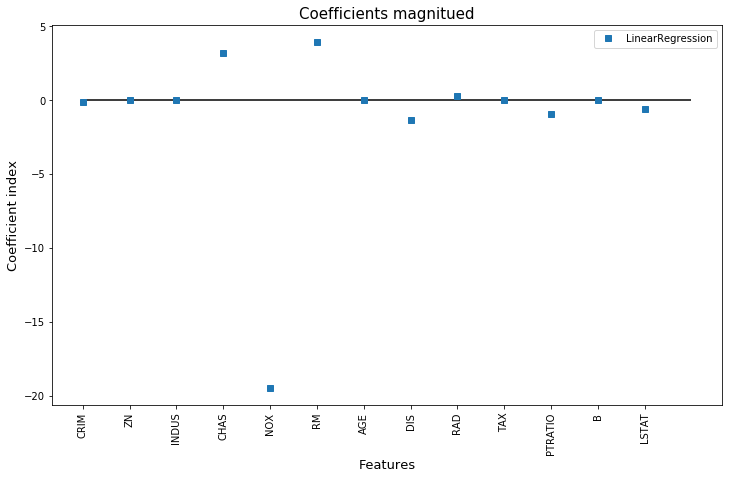

In [323]:
plot_coefficients_given_models(boston_houses_ds, lr)

## Ridge e Lasso
Ordinary Least Square presents a regularization problem due to some of its coefficient magnitudes tends to assume high values fitting on the training data. Ridge and lasso add a constraint on the optimization function in order to limit these phenomena. 

The Ridge regularization: 
$$ \min_{w} || X w - y||_2^2 + \alpha ||w||_2^2 $$

The Lasso Regularization: 
$$ \min_{w} { \frac{1}{2n_{\text{samples}}} ||X w - y||_2 ^ 2 + \alpha ||w||_1} $$

<div class="alert alert-info" role="alert">
    
<img src="./icons/list.png"  width="20" height="20" align="left"> &nbsp;  **Exercise 3: Linear Models with regularization**  

Try to repeat the regression experiment using `Ridge` and compare the performances with the `LinearRegression` model.

To see the different coefficient magnitudes use the `plot_coefficients_given_models` with a given dataset and pass a list of trained models in order to compare the results.
</div>

In [324]:
ridge = Ridge(alpha=0.3)

In [325]:
ridge.fit(X_train, y_train)

Ridge(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [326]:
ridge.coef_

array([-1.36460629e-01,  3.95117790e-02,  1.48240106e-02,  3.04746053e+00,
       -1.45299706e+01,  3.98919676e+00, -6.22504897e-03, -1.26379121e+00,
        2.82294074e-01, -8.75832456e-03, -8.85028932e-01,  9.14423565e-03,
       -5.66661683e-01])

In [332]:
y_pred_ridge = ridge.predict(X_test)
y_pred_r_tr = ridge.predict(X_train)

In [339]:
ridge_100 = Ridge(alpha=100).fit(X_train, y_train)

In [340]:
ridge_100.coef_

array([-1.38829700e-01,  4.54818914e-02, -3.60761745e-02,  4.34352467e-01,
       -1.66625622e-01,  1.94020966e+00, -8.65324121e-04, -9.95871809e-01,
        3.02188474e-01, -1.20265622e-02, -8.27205721e-01,  8.89294639e-03,
       -7.38583833e-01])

In [341]:
y_pred_ridge100 = ridge_100.predict(X_test)
y_pred_r_tr100 = ridge_100.predict(X_train)

In [330]:
print("Error Linear model training: ", mean_squared_error(y_train, y_pred_tr))
print("Error Linear model test: ", mean_squared_error(y_test, y_pred))

Error Linear model training:  20.6706026210102
Error Linear model test:  24.525135733775528


In [333]:
print("Error Ridge model training: ", mean_squared_error(y_train, y_pred_r_tr))
print("Error Ridge model test: ", mean_squared_error(y_test, y_pred_ridge))

Error Ridge model training:  20.74238683396347
Error Ridge model test:  24.4573096274263


In [342]:
print("Error Ridge (alpha=100) model training: ", mean_squared_error(y_train, y_pred_r_tr100))
print("Error Ridge (alpha=100) model test: ", mean_squared_error(y_test, y_pred_ridge100))

Error Ridge (alpha=100) model training:  23.500911632126204
Error Ridge (alpha=100) model test:  26.508520349802666


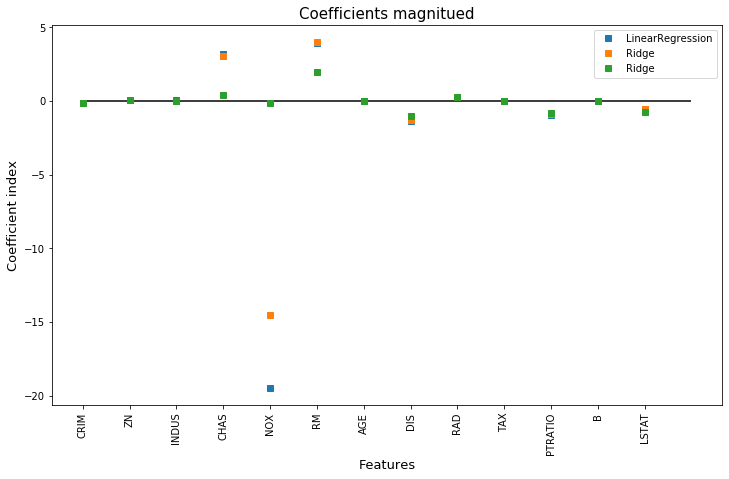

In [343]:
plot_coefficients_given_models(boston_houses_ds, [lr, ridge, ridge_100])

<hr>

## Decision Tree
The last model we are going to see in this notebook is the Decision Tree for classification. We can compare the different scores obtained with the different classifiers and see witch performs better.

Please note that the decision tree has more hyperparameters in comparison with the K-Nearest Neighbor. The ones you can play with are: 
- `max_depth`: controls the complexity of the model
- `min_sample_split`: min number of samples to allow a split in an internal node. If the node is not split it is considered as a leaf, thus the distribution of samples in the leaf would affect the final decision.


<div class="alert alert-info" role="alert">
    
<img src="./icons/list.png"  width="20" height="20" align="left"> &nbsp;  **Exercise 4: Decision Trees**
- split the *breast cancer* dataset in training and test sets 
- fit the model on the training data
- make predictions on the test data
- observe the obtained performances
</div>

In [344]:
print(breast_ds.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

In [345]:
X, y = breast_ds.data, breast_ds.target

In [346]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=R_STATE)

In [386]:
dcc = DecisionTreeClassifier(max_depth=10, random_state=90)

In [395]:
dcc.tree_

In [387]:
dcc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=90, splitter='best')

In [388]:
y_pred = dcc.predict(X_test)

In [389]:
dcc.predict(X_test[:5])

array([1, 1, 1, 1, 1])

In [390]:
dcc.predict_proba(X_test[:5])

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [391]:
print("Test score: ", accuracy_score(y_test, y_pred))

Test score:  0.9300699300699301


### Visualize Decision Tree Structure
It is possible to check how the tree has been built. Use the below `plot_decision_tree(dataset, model)` function to plot the tree. You can also try with different parameters and see how those impact the tree construction.

<div class="alert alert-success" role="alert">
    
<img src="./icons/lightbulb.png"  width="20" height="20" align="left"> &nbsp; **SciKit-Learn Tip 3: Reproducibility**

Sometimes we want to have the same output across different runs of the algorithm. Due to the majority of them uses pseudo random generators it is possible to fix the seed of those using the `random_state` parameter.

</div>

In [392]:
def plot_decision_tree(dataset, model):
    dot_data = StringIO()
    export_graphviz(model, out_file=dot_data,
                    feature_names=dataset.feature_names,
                    class_names=True,
                    filled=True, rounded=True,
                    special_characters=True)

    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return Image(graph.create_png())

In [393]:
iris_ds.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

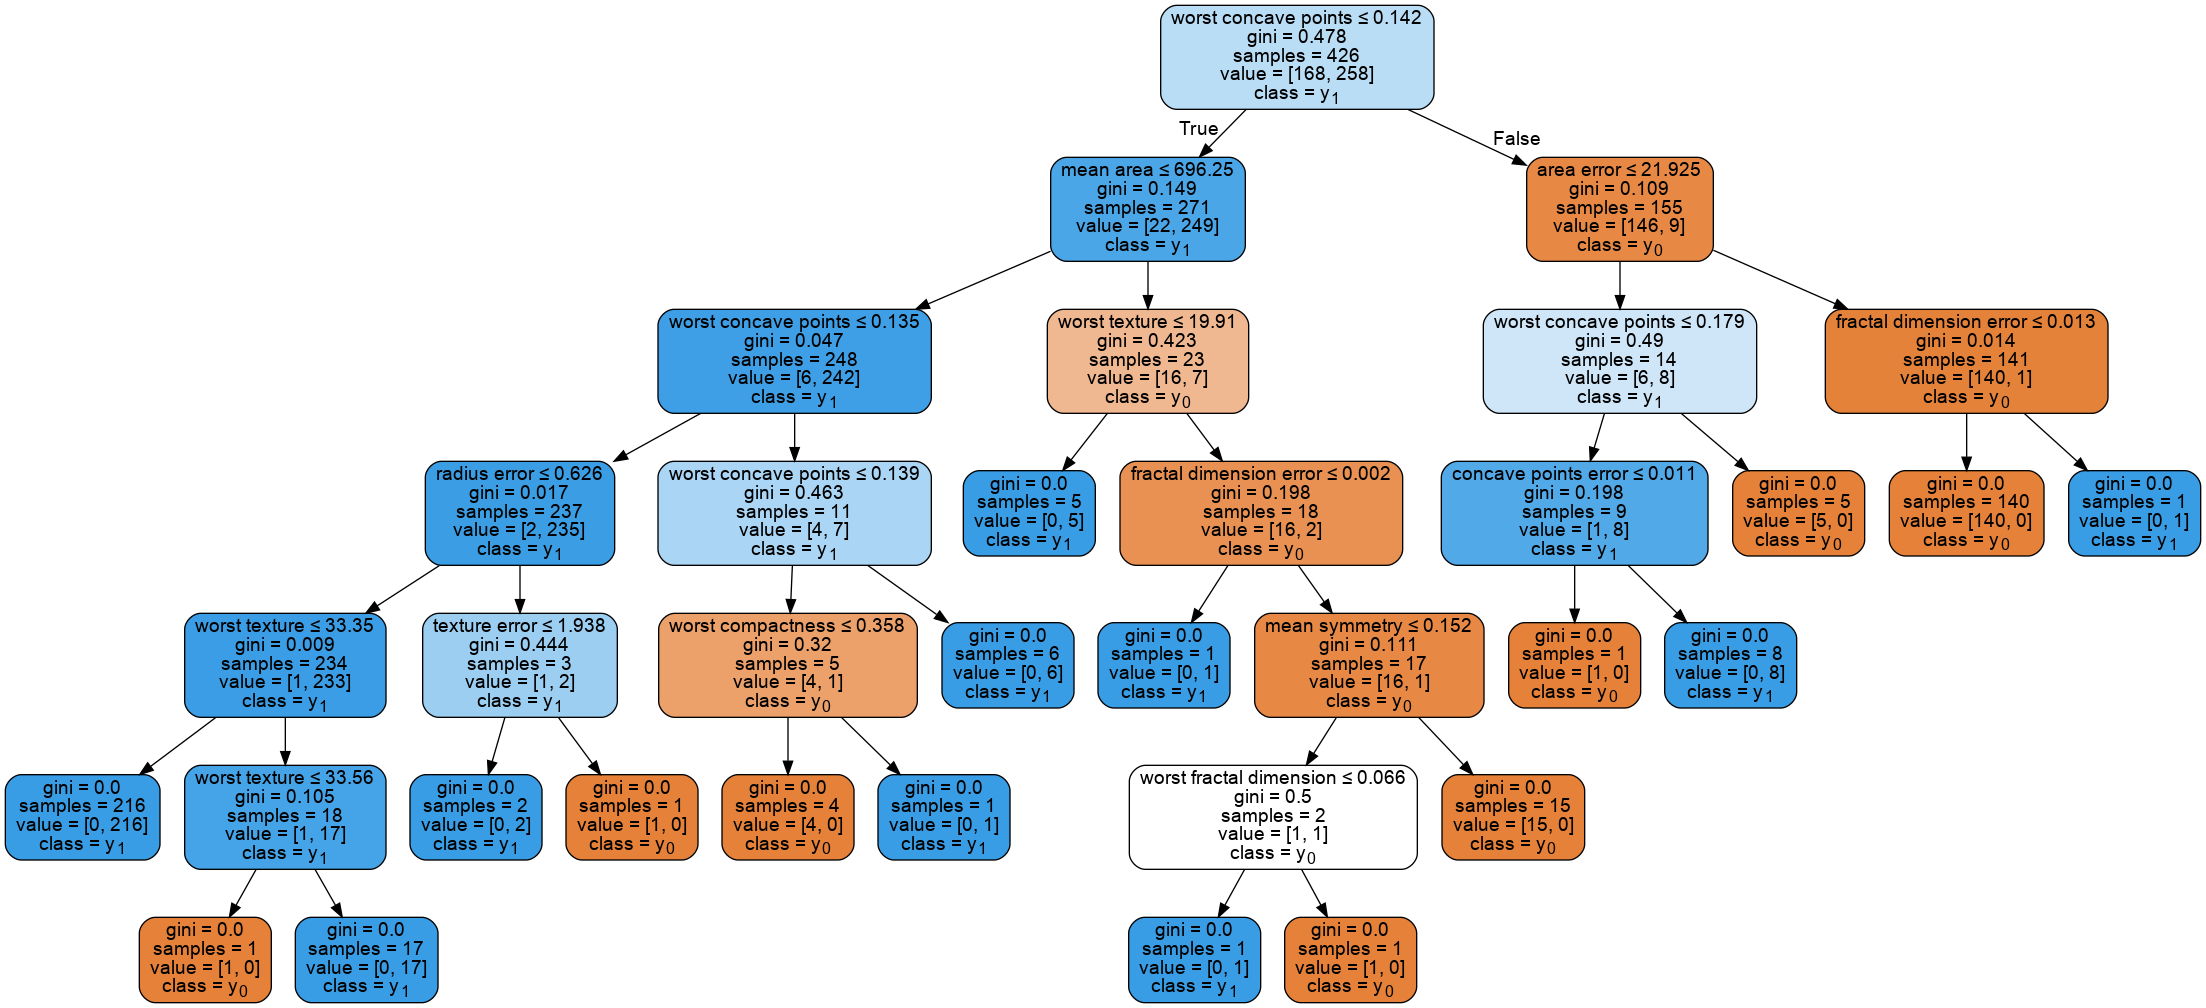

In [394]:
plot_decision_tree(breast_ds, cdt)

<hr>

## K-Nearest Neighbor: Classification
The first model we are going to use is the KNN which is a very simple model to start with. KNN can be used for both for classification or regression tasks. Here we are going to see classification first. 

<div class="alert alert-info" role="alert">
    
<img src="./icons/list.png"  width="20" height="20" align="left"> &nbsp;  **Exercise 5: Classification with KNN**
- split the breast cancer dataset in training and test sets 
- instantiate a KNN classifier specifying *n_neighbours* in the constructor
- fit the model on the training data
- make predictions on the test data
- observe the obtained performances
</div>

In [397]:
X, y = breast_ds.data, breast_ds.target

In [398]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=R_STATE)

In [399]:
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')

In [400]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='distance')

In [403]:
y_pred = knn.predict(X_test)

In [404]:
knn.predict_proba(X_test[:5])

array([[0.32367898, 0.67632102],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ]])

In [408]:
accuracy_score(y_test, y_pred)

0.9370629370629371

### KNN Model complexity

<div class="alert alert-warning" role="alert">
    
<img src="./icons/book.png"  width="20" height="20" align="left"> &nbsp;  **Theory: Model Complexity** 

The number of neighbors determines the complexity of the model. 

A lower value leads to a higher model complexity which means that the model would be very sensitive to noise (when a point of a class is in a region populated the most by the other class points). 

Vice versa, in the case of an higher number of neighbors used to evaluate the point's class the presence of noise is less relevant.
</div>

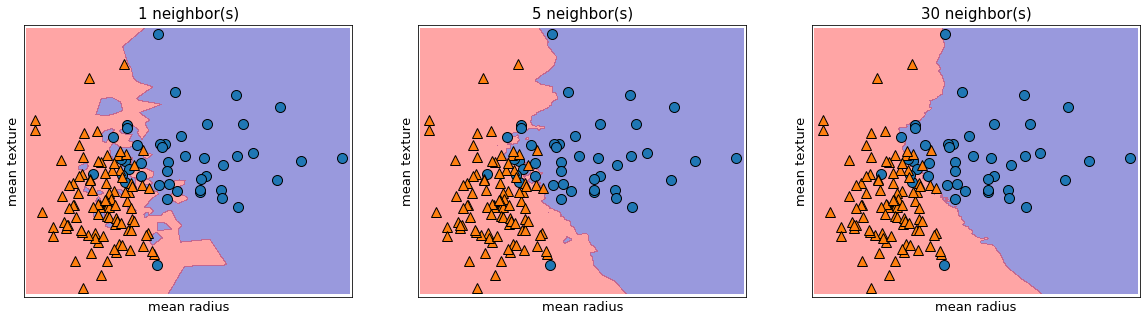

In [411]:
plot_visual_boundaries(breast_ds, [1, 5, 30])

### Which k ?
It is possible to train different models on different values of k and observe the performance of the model on the test set. Use the provided `k_search_classification()` function for searching k.

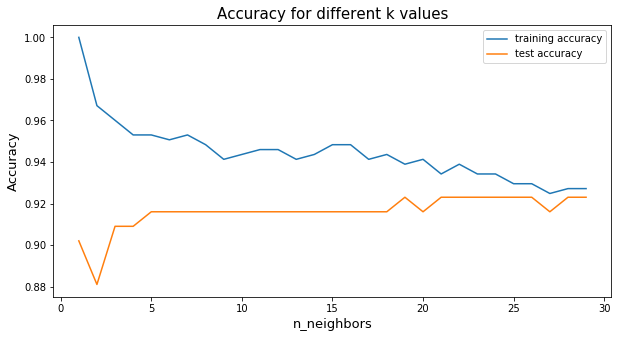

In [410]:
k_search_classification(breast_ds, range(1, 30))

<hr>

## K-Nearest Neighbor: Regression


<div class="alert alert-info" role="alert">
    
<img src="./icons/list.png"  width="20" height="20" align="left"> &nbsp;  **Exercise 6: Regression with KNN**
- split the *diabetes dataset* in training and test sets 
- instantiate a KNN classifier specifying *n_neighbours* in the constructor
- fit the model on the training data
- make predictions on the test data
- observe the obtained performances
</div>

In [412]:
print(diabetes_ds.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bra

In [413]:
X, y = diabetes_ds.data, diabetes_ds.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=R_STATE)

In [414]:
knnr = KNeighborsRegressor(n_neighbors=3)

In [416]:
knnr.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                    weights='uniform')

In [417]:
pred_y = knnr.predict(X_test)

In [422]:
pred_y

array([133.        , 199.66666667, 118.        , 271.33333333,
       136.33333333, 209.66666667, 231.33333333, 114.33333333,
       141.33333333, 234.66666667, 111.        , 179.        ,
       134.33333333, 132.33333333, 213.        , 250.33333333,
       258.        , 136.66666667, 101.33333333, 190.33333333,
       159.33333333, 167.33333333, 121.        , 140.33333333,
       153.33333333, 280.66666667, 109.33333333, 157.66666667,
       252.66666667, 110.33333333, 158.33333333, 125.33333333,
       152.        , 217.        ,  79.        , 166.66666667,
       220.        , 133.66666667, 256.33333333, 213.        ,
        61.        , 201.33333333, 199.66666667, 136.33333333,
        93.33333333, 143.33333333, 153.66666667, 108.        ,
       267.66666667, 249.33333333, 118.66666667, 238.33333333,
        53.33333333, 235.66666667, 141.33333333, 167.66666667,
       139.33333333, 246.33333333, 239.66666667, 113.        ,
       259.33333333,  57.        , 131.        , 177.66

In [421]:
np.sqrt(mean_squared_error(y_test, pred_y))

61.034639568258505

### Regression Analysis 
We can observe how the model works on a single feature of the dataset on the given target.
Plot the regression results with the provided `plot_regression()` function.

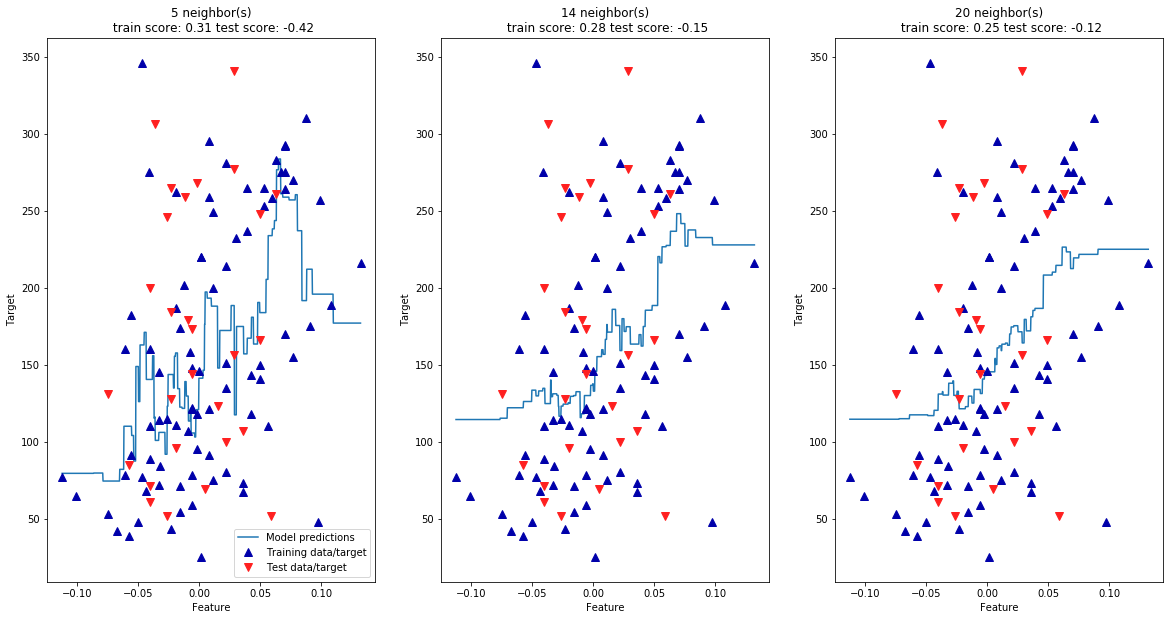

In [424]:
plot_regression(diabetes_ds, [5, 14, 20], f_number=3)

<hr>

Which is the best k? Use the provided `k_search_regression()` function to figure it out!

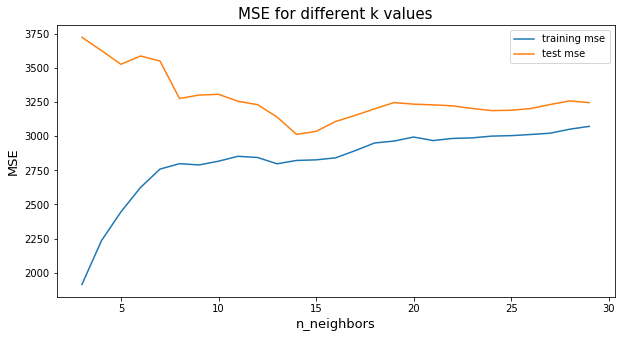

In [425]:
k_search_regression(diabetes_ds, range(3, 30))

<hr>

## Homeworks

<div class="alert alert-danger" role="alert">
    
<img src="./icons/chemistry.png"  width="20" height="20" align="left"> &nbsp;  **Task 1.1**:  Using the `KNeighborsClassifier` model try to repeat the training using the **iris** dataset.
- compute the score using the `accuracy_score`

[**SOLUTION**](./solutions/handson3/solution_1.1.py)
</div>

<div class="alert alert-danger" role="alert">
    
<img src="./icons/chemistry.png"  width="20" height="20" align="left"> &nbsp;  **Task 1.2**:  Continure the analysis by manipulating some of the features.
- add new features by combining existing ones (see the iris dataset description for some insights).
- remove existing features.

To help you manipulating the dataset, I have provided you with a function which gives you a `pandas.DataFrame` X_df with the features and a `pandas.Series` with the target.

[**SOLUTION**](./solutions/handson3/solution_1.2.py)
</div>

In [ ]:
def create_dataframe_series(dataset): 
    return (
        pd.DataFrame(dataset.data, columns=[x.replace(" ", "_") for x in dataset.feature_names]), 
        pd.Series(dataset.target, name="target")
    )

<div class="alert alert-danger" role="alert">
    
<img src="./icons/chemistry.png"  width="20" height="20" align="left"> &nbsp;  **Task 2**:   Using the `KNeighborsRegressor` model try to repeat the training using the **Boston Houses** dataset.
- compute the score using the `r2_score` or the `mean_squared_error`

[**SOLUTION**](./solutions/handson3/solution_2.py)

</div>

<div class="alert alert-danger" role="alert">
    
<img src="./icons/chemistry.png"  width="20" height="20" align="left"> &nbsp;  **Task 3**:   Using the `DecisionTreeRegressor` model try to repeat the training using the **Boston Houses** dataset.
- compute the score using the `r2_score` or the `mean_squared_error`
- try different parametrization for the Tree in order to observe the performances. [API](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)

[**SOLUTION**](./solutions/handson3/solution_3.py)
</div>

<div class="alert alert-danger" role="alert">
    
<img src="./icons/chemistry.png"  width="20" height="20" align="left"> &nbsp;  **Task 4**: Using the **Breast Cancer**  dataset: 

- try to repeat the regression experiment using the `Lasso` model and compare the performances with the `LinearRegression` and `Ridge` models.
- use `plot_coefficients_given_models` with the Breast Cancer dataset and pass a list of trained models in order to compare the results.
[**SOLUTION**](./solutions/handson3/solution_4.py)
</div>

<div hidden=True>
<img src="./icons/list.png"  width="20" height="20" align="left"> &nbsp; Icon made by <a href="https://www.flaticon.com/authors/smashicons" title="Smashicons">Smashicons</a> from <a href="https://www.flaticon.com/"             title="Flaticon">www.flaticon.com</a>

<img src="./icons/lightbulb.png"  width="20" height="20" align="left"> &nbsp;Icon made by <a href="https://www.flaticon.com/authors/pixelmeetup" title="Pixelmeetup">Pixelmeetup</a> from <a href="https://www.flaticon.com/"             title="Flaticon">www.flaticon.com</a>

<img src="./icons/new.png"  width="20" height="20" align="left"> &nbsp; Icon made by <a href="https://www.flaticon.com/authors/pixel-perfect" title="Pixel perfect">Pixel perfect</a> from <a href="https://www.flaticon.com/"             title="Flaticon">www.flaticon.com</a>

<img src="./icons/chemistry.png"  width="20" height="20" align="left"> &nbsp; Icon made by <a href="https://www.flaticon.com/authors/popcorns-arts" title="Icon Pond">Icon Pond</a> from <a href="https://www.flaticon.com/"             title="Flaticon">www.flaticon.com</a>

<img src="./icons/book.png"  width="20" height="20" align="left"> &nbsp; Icon made by <a href="https://www.flaticon.com/authors/popcorns-arts" title="Icon Pond">Icon Pond</a> from <a href="https://www.flaticon.com/"             title="Flaticon">www.flaticon.com</a>
    
</div>